1A - Convolutional Network(Please see comments beside the code)

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.name = "model"
    self.conv1 = nn.Conv2d(3,5,5)              #output channel = 5, kernel size = 5x5, used from lecture notes
    self.pool1 = nn.MaxPool2d(4,4)             #reduces out put by 4 times instead of half because I think 224*224 requires more consolidation since it's big
    self.conv2 = nn.Conv2d(5,10,6)             #output channel = 10 to compensate for potential information loss from pool operation above. kernel size = 6x6 because I want the output to be 10x50x50
    self.pool2 = nn.MaxPool2d(5,5)             #reduce output by 5 times since the input for this operation becomes 50*50 so the output will be 10*10
    self.fc1 = nn.Linear(10*10*10, 100)        #fully connected layer. nn.linear to convert 1000 data input into 100 output
    self.fc2 = nn.Linear(100,9)                #compute into 9 final outputs as there are 9 letters
      
  def forward(self, x):                                       #input image is 3x224x224
    x = self.pool1(F.relu(self.conv1(x)))                     #apply conv1, turns into 5x220x220, apply pool1, turns into 5x55x55
    x = self.pool2(F.relu(self.conv2(x)))                     #apply conv2, turns into 10x50x50, apply pool2, turns into 10x10x10
    x = x.view(-1, 10 * 10 * 10)                              #flattens image
    x = F.relu(self.fc1(x))                                   #apply relu activetion function to make sure it's not linear relationship, output=100
    x = self.fc2(x)                                           #output = 9
    return x 
    
 


1B and 1C  (Please see graph below. It is suggesting that the model overfits quickly. It reaches 100% accuracy very quickly because I only used 16 images as the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!unzip '/content/gdrive/My Drive/asl_data.zip'
images = torchvision.datasets.ImageFolder(root='asl_data/', transform=transforms.ToTensor())
images = list(images)


In [ ]:
def get_accuracy(model, train=False):
    if train:
        data = debug
    else:
        data = val_set

    correct = 0
    total = 0
    for imgs,labels in torch.utils.data.DataLoader(data, batch_size=32):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total  

def test_accuracy(model, train=False):
    if train:
        data = train_set
    else:
        data = test_set

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=8):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total  
  
def get_accuracy_alex(model, train=False):
    if train:
        data = train_set
    else:
        data = val_set

    correct = 0
    total = 0
    for imgs,labels in torch.utils.data.DataLoader(data, batch_size=64):
        features = alexnet.features(imgs)
        output = model(features)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total  

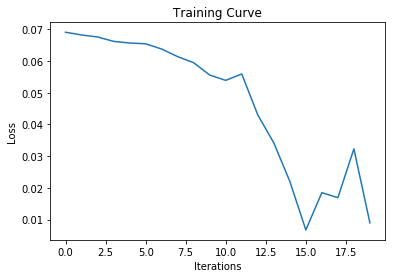

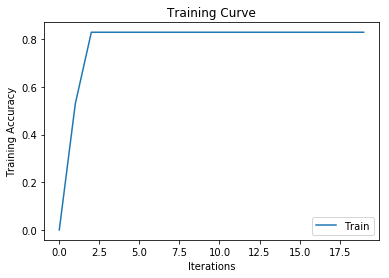

In [ ]:


model = Model()                             #it is overfitting very quickly because I only used 100 images(mostly "A"s ) and batch size = 32, so 1 epoch=3 iterations
debug = train_set[0:100]                    #It's not the best choice of hyperparameters and data spliting, but it's enough to prove that the network is working    
def train_test(model, data, batch_size=32, num_epochs=5):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle=True)
    criterion = nn.CrossEntropyLoss()                                             #Choose CrossEntropyLoss for loss function since we have 9 outputs
    optimizer = optim.SGD(model.parameters(), lr=0.01)                           #Choose Stochastic gradient descent optimizer because I think this is a more essential method when testing on a small data set
    iters, losses, train_acc, val_acc = [], [], [], []           
                                                                    
        # training
    n = 0                         
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)  
            loss = criterion(out, labels)
            loss.backward()            
            optimizer.step()             
            optimizer.zero_grad()                                   
            iters.append(n)                            
            losses.append(float(loss)/batch_size)                  
            train_acc.append(get_accuracy(model, train=True))
           # val_acc.append(get_accuracy(model, train=False))  
            n += 1
           
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
   # plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    
    

  
  
model = Model()
train_test(model,debug)                  

Part 2 Data Splitting.

My thought process behind this data spliting is to leave a small portion of the complete dataset as test set, which contains hands that the network has never seen before. I would leave 9 pictures for each gessture(81 pictures in total) as test set. For the rest the data, I would leave 2/3 of them as training data and 1/3 as validation data. So for each of the letter from each student, 2 will be training and 1 will be validation. I did it manually, and had 3 separate zip files. The final ratio is about train:val:test = 6:3:1

In [ ]:
#load datasets
!unzip '/content/gdrive/My Drive/train_set.zip'
train_set = torchvision.datasets.ImageFolder(root='train_set/', transform=transforms.ToTensor())
train_set = list(train_set)
!unzip '/content/gdrive/My Drive/val_set.zip'
val_set = torchvision.datasets.ImageFolder(root='val_set/', transform=transforms.ToTensor())
val_set = list(val_set)
!unzip '/content/gdrive/My Drive/test_set.zip'
test_set = torchvision.datasets.ImageFolder(root='test_set/', transform=transforms.ToTensor())
test_set = list(test_set)

Part 3

In [ ]:

def train(model, data, batch_size=64, num_epochs=30):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss\
            #val_loss.append(get_val_loss(model,val_loader,criterion))
            train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training loss")
    plt.plot(iters, losses, label="Train")
   # plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


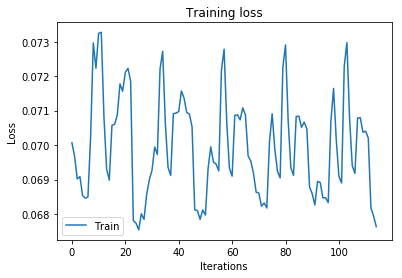

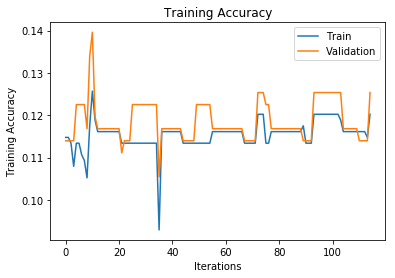

Final Training Accuracy: 0.12021857923497267
Final Validation Accuracy: 0.12535612535612536


In [ ]:
    #epoch = 5, lr = 0.01,batch=32
model = Model()
train(model,train_set) 

Part 4A:

1. Batch size
2. Learning Rate
3. Number of epochs

Part 4B 

Adjust learning rate to 0.005 and batch to 64 to reduce noise and add shuffle=true

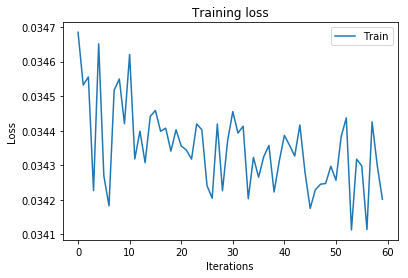

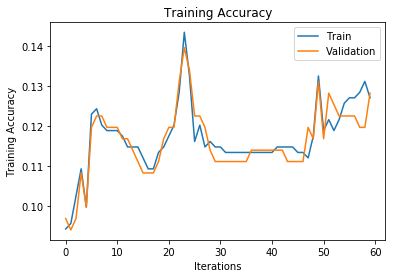

Final Training Accuracy: 0.12704918032786885
Final Validation Accuracy: 0.1282051282051282


In [ ]:
 #epoch = 5, lr = 0.005,batch=64
model = Model()
train(model,train_set)

adjust epoch to 10 and batch size = 64

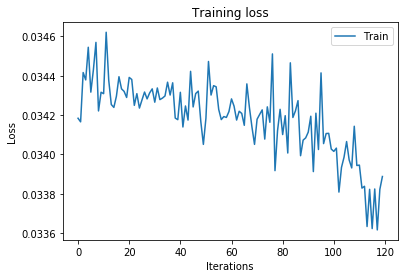

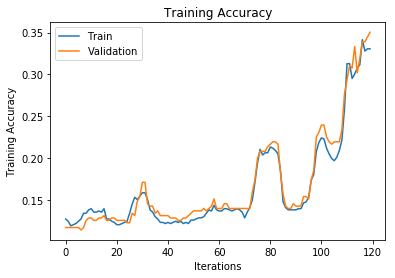

Final Training Accuracy: 0.33060109289617484
Final Validation Accuracy: 0.3504273504273504


In [ ]:
 #epoch = 10, lr = 0.005,batch=64
model = Model()
train(model,train_set)

adjust epoch to 30 ( learning rate is too small. Still underfit after training)

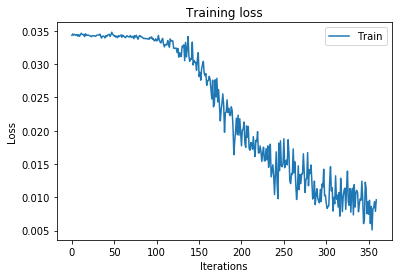

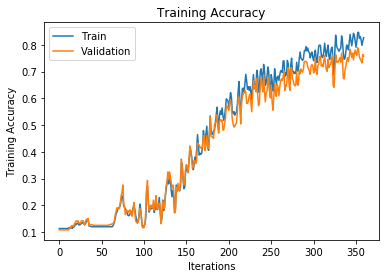

Final Training Accuracy: 0.8265027322404371
Final Validation Accuracy: 0.7578347578347578


In [ ]:
#epoch = 30, lr = 0.005,batch=64
model = Model()
train(model,train_set)

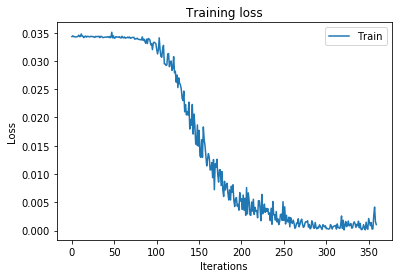

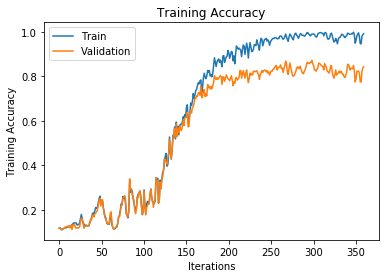

Final Training Accuracy: 0.9918032786885246
Final Validation Accuracy: 0.8433048433048433


In [ ]:
#epoch = 30, lr = 0.01,batch=64
model = Model()
train(model,train_set)

In [ ]:

PATH = get_model_name(model.name, 64, 0.01, 30)
torch.save(model.state_dict(), PATH)                                       #Save the model



In [ ]:
#load model
model = Model()
model.load_state_dict(torch.load(PATH))
model.eval()

Part 4C:

The best model so far is the one above, with hyperparameters epoch=30, learning rate=0.01, batch size=64. Because it has the leat noise compared to other models, highest final train and validation accuracy, and indicates where the overfits starts(@about 180 iterations or around 19 epochs)

Part 4D

In [ ]:

def test(model, data, batch_size=81, num_epochs=1):
  
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    iters, losses, train_acc, test_acc = [], [], [], []


    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(test_loader):
            out = model(imgs)             # forward pass
            # save the current training information
            iters.append(n)
            test_acc.append(test_accuracy(model, train=False))   
            n += 1
    print(test_acc[-1])



In [ ]:
test(model,test_set)   # Test Accuracy of chosen model

0.5375


Part 5A

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:04<00:00, 53036895.39it/s]


In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)

for imgs, labels in train_loader:
  train_features = []
  features = alexnet.features(imgs)
  train_features.append(features)

In [ ]:
for imgs, labels in val_loader:
  val_features = []
  features = alexnet.features(imgs)
  val_features.append(features)

In [ ]:
for imgs, labels in test_loader:
  test_features = []
  features = alexnet.features(imgs)
  test_features.append(features)

Part 5B

In [ ]:
import torch.nn.functional as F
class Classifier(nn.Module):
  def __init__(self,num_hidden):
    super(Classifier,self).__init__()                     #Only fully connected layers because alexnet.features already  did the convolution part
    self.name = "Classifier"
    self.fc1 = nn.Linear(256*6*6,1000)                    #First layer dimensions need to match the output of alexnet which is 256x6x6. Output of this layer is 1000
    self.fc2 = nn.Linear(1000,100)                        #Second layer output is 100, I want the compression ratio to be constant between layers. 
    self.fc3 = nn.Linear(100,9)                           #output of the final model has 9 outputs.
    self.num_hidden = num_hidden

  def forward(self, x):
    x = x.view(-1, 256*6*6)                               #flattens image
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))                               #apply relu activation function to make sure it's not linear relationship, output=100
    x = self.fc3(x)                          

    
    return x
  
  

Part 5C : The best hyperparameter I found is batch size=64, epochs = 30, lr =0.01

In [ ]:
def train_alex(model, data, batch_size=64, num_epochs=30):
    train_loader= torch.utils.data.DataLoader(data, batch_size=batch_size,shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []
    train_features = []
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in (train_loader):
            features = alexnet.features(imgs)
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy_alex(model, train=True)) # compute training accuracy 
            val_acc.append(get_accuracy_alex(model, train=False))  # compute validation accuracy
            n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

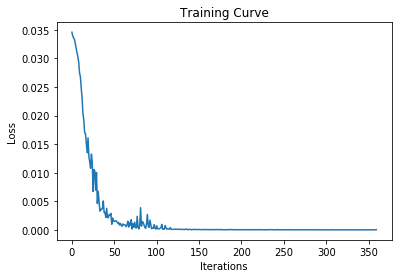

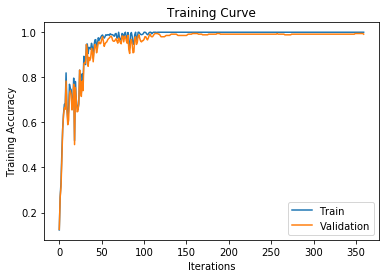

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9914529914529915


In [ ]:
model = Classifier()
train_alex(model,train_set)


5D: By using transfer learning, using a image from test set, which is completely a new hand that the network has never seen during training, predicts 99.9% probability. This is far more accurate than what I got from 4D (@53.75% accuracy)

In [ ]:
for imgs, labels in (test_loader):
  features = alexnet.features(imgs)
output = model(features)
prob = F.softmax(output, dim=1)
print(prob)

tensor([[7.2321e-10, 5.8658e-12, 3.4840e-09, 7.0207e-10, 7.4566e-07, 2.8434e-07,
         8.0948e-06, 7.3049e-08, 9.9999e-01]], grad_fn=<SoftmaxBackward>)


In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)
for imgs, labels in (test_loader):
  features = alexnet.features(imgs)
  output = model(features)
  prob = F.softmax(output, dim=1)
  print(prob)

tensor([[9.9672e-01, 2.0868e-08, 3.9810e-07, 3.6327e-09, 3.2409e-03, 7.9833e-08,
         1.6101e-07, 2.3862e-06, 3.2425e-05]], grad_fn=<SoftmaxBackward>)
tensor([[9.9943e-01, 2.2230e-09, 2.9212e-07, 1.0743e-09, 5.5638e-04, 3.9793e-08,
         8.1533e-08, 1.1738e-06, 1.1056e-05]], grad_fn=<SoftmaxBackward>)
tensor([[9.9994e-01, 1.0011e-09, 4.4077e-08, 6.7846e-10, 5.9810e-05, 3.0590e-10,
         4.9224e-08, 6.6003e-08, 3.2508e-07]], grad_fn=<SoftmaxBackward>)
tensor([[7.4360e-04, 8.1349e-07, 1.2880e-03, 7.8003e-03, 3.7169e-05, 1.0461e-04,
         9.8667e-01, 1.8325e-04, 3.1755e-03]], grad_fn=<SoftmaxBackward>)
tensor([[3.2412e-03, 5.2106e-06, 2.0513e-02, 2.1227e-02, 7.9127e-04, 3.7226e-03,
         8.4149e-01, 1.3273e-02, 9.5736e-02]], grad_fn=<SoftmaxBackward>)
tensor([[1.5493e-03, 1.9473e-06, 4.4506e-03, 9.8424e-03, 1.4276e-04, 8.5242e-04,
         9.2491e-01, 1.4911e-03, 5.6756e-02]], grad_fn=<SoftmaxBackward>)
tensor([[9.9988e-01, 6.1430e-09, 1.5800e-05, 1.1977e-07, 1.0278e-04, 2